<a href="https://colab.research.google.com/github/AnnaPakir/toxicity-test/blob/main/Toxid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для «Викишоп»

**Описание проекта:** Комментарии под товаром в онлайн-магазинах позволяют сделать выбор покупателю в пользу одного или другого товара. В тоже время данные комментарии должны быть информативны и позезны. Токсичные комментарии в тоже время, не дают информации, а дают лишь эмоции, часто не связанные с самим товаром. С помошью данных о комментариях мы строим модели машинного обучения, позволяющие оценить токсичность комментариев и иметь возможность отправлять подобные ответы на модерацию.  <br>

**Цель исследования:** создать модели машинного обучения,позволяющей определить токсичность комментариев.<br>

**Ход исследования:**
Для выполнения цели исследования необходимо будет выполнить следующие задачи:
- <u>Первоначальный анализ и предобраотка данных.</u> Загрузка данных, первоначальное их изучение и анализ, их предобработка
- <u>Обучние моделей.</u> Создание модели машинного оучения, подбор гипперпараметров, анализ моделей  
- <u>Вывод </u> Описание результатов исследования, выводы.

Данное исследование может стать основой для исследования и планирование работы с комментариями.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
import spacy
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [ ]:
from tqdm.notebook import tqdm  # обеспечим себе возможность следить за ходом работы лемматизации
tqdm.pandas()

In [ ]:
from warnings import simplefilter  # удаляем комментарии программы
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

Загрузка датасета, его первоначальное изучение.

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv', sep=',')

In [ ]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Проверили датесет. Он оказался без пропусков и нормальными типами столбцов. Далее обработаем текстовую информацию: исключим верхний регистр, исключим небуквенные символы и проведем лемматизацию.

In [ ]:
df['ver1'] = df['text'].apply(lambda x: x.lower())

In [ ]:
def drop_simv(line):
    # удаляем неалфавитные символы
    text = re.sub("[^a-z]", " ", line)
    return ' '.join(text.split())

In [ ]:
df['ver1'] = df['ver1'].apply(drop_simv)

In [ ]:
disabled_pipes = ["parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)

In [ ]:
lemm_texts = []

for doc in tqdm(nlp.pipe(df['ver1'].values, disable=['ner', 'parser']), total=df.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc])
    lemm_texts.append(lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
df['lemm_text'] = lemm_texts

Лемматизация работает, можно удалить ненужные столбцы.

In [ ]:
df[['text', 'lemm_text']].head(10)

,text,lemm_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",congratulation from I as well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,alignment on this subject and which be contrar...


In [ ]:
df = df.drop(['Unnamed: 0', 'text', 'ver1'], axis=1)

In [ ]:
df.head()

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m seem...
2,0,hey man I m really not try to edit war it s ju...
3,0,more I can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [ ]:
df.duplicated().sum()

1316

In [ ]:
df = df.drop_duplicates() # удяляем дубликаты, они не помогут работе моделей

In [ ]:
df.head()

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m seem...
2,0,hey man I m really not try to edit war it s ju...
3,0,more I can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


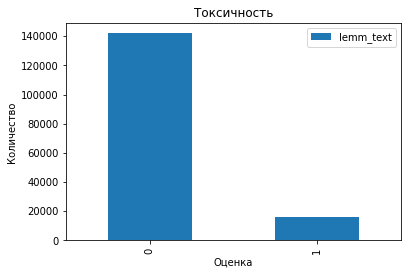

In [ ]:
df.pivot_table(index = 'toxic', values = 'lemm_text', aggfunc = 'count').plot(kind = 'bar')
plt.title('Токсичность')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

Вывод по 1 части
На данном этапе был просмотрене датафрейм. Столбец с комментариями был проведен в лемматизированный вид, удалены лишные символы и дубликаты. Целевой признак несогласован, комментариев без токсичности в несколько раз больше.   

## Обучение

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        df['lemm_text'],
        df['toxic'],
        shuffle=False,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE)

In [ ]:
print(X_train.shape, '- размер данных для тренировки')

(142178,) - размер данных для тренировки


In [ ]:
print(X_test.shape, '- размер данных для теста')

(15798,) - размер данных для теста


In [ ]:
pipe_tree = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('models',  LogisticRegression())
])

In [ ]:
param_grid = [
    {
        'models':  [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear')],
        'models__C': range(5, 7)
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(9, 10),
        'models__max_leaf_nodes': range(10, 12),
    },
    {
        'models': [KNeighborsClassifier()],
    }
]

In [ ]:
search = GridSearchCV(
    pipe_tree,
    param_grid,
    cv=3,
    scoring='f1',
    verbose=10
)

In [ ]:
search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', search.best_params_)
print('Метрика лучшей модели на кросс-валидации :', search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5
[CV 1/3; 1/5] END models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5; total time=  22.3s
[CV 2/3; 1/5] START models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5
[CV 2/3; 1/5] END models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5; total time=  21.5s
[CV 3/3; 1/5] START models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5
[CV 3/3; 1/5] END models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=5; total time=  19.5s
[CV 1/3; 2/5] START models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=6
[CV 1/3; 2/5] END models=LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), models__C=6;

In [ ]:
result = pd.DataFrame(search.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__max_depth,param_models__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,19.142900,1.152415,1.975069,0.029310,"LogisticRegression(C=6, max_iter=1000, random_...",5,NaN,NaN,"{'models': LogisticRegression(C=6, max_iter=10...",0.782783,0.773071,0.775770,0.777208,0.004093,2
1,18.671027,0.227695,2.001954,0.009602,"LogisticRegression(C=6, max_iter=1000, random_...",6,NaN,NaN,"{'models': LogisticRegression(C=6, max_iter=10...",0.783341,0.774452,0.779202,0.778999,0.003632,1
2,8.683424,0.041563,2.035939,0.025858,DecisionTreeClassifier(random_state=42),NaN,9,10,{'models': DecisionTreeClassifier(random_state...,0.604562,0.601264,0.608837,0.604888,0.003100,3
3,8.606146,0.071652,1.990264,0.017863,DecisionTreeClassifier(random_state=42),NaN,9,11,{'models': DecisionTreeClassifier(random_state...,0.600445,0.591280,0.605358,0.599027,0.005834,4
4,4.144716,0.039167,263.296998,5.763241,KNeighborsClassifier(),NaN,NaN,NaN,{'models': KNeighborsClassifier()},0.198563,0.201197,0.199601,0.199787,0.001083,5


In [ ]:
print('Лучшая модель и её параметры:\n\n', search.best_params_)
print('Метрика лучшей модели на кросс-валидации:', search.best_score_)

Лучшая модель и её параметры:

 {'models': LogisticRegression(C=6, max_iter=1000, random_state=42, solver='liblinear'), 'models__C': 6}
Метрика лучшей модели на кросс-валидации: 0.7789985392838346


In [ ]:
y_pred = search.predict(X_test)

In [ ]:
print('f1 на тестовой выборке:', f1_score(y_true=y_test, y_pred=y_pred))

f1 на тестовой выборке: 0.7813471502590674


## Выводы

В данном проeкте был разобран датасет с  разметкой о токсичности фраз. В процессе работы была проведена обработка текста, были исключены все небуквенные символы, проведена лемматизация. При обучении моделей машинного обучения лучше всего себя показала модель логической регрессии. На тестовой выборке ее метрика 0.78. Данная модель с неплохим качеством позволяет искать токсичные комментирии и отправлять их на модерацию.  